In [2]:
import re
import csv
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_lg')
from spacy.matcher import Matcher 
from spacy.tokens import Span 
import urllib.request 
from bs4 import BeautifulSoup
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

/Users/danielwidjaja/github/datathon-2025/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/danielwidjaja/github/datathon-2025/venv/lib/python3.11/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/Users/danielwidjaja/github/datathon-2025/venv/lib/python3.11/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [3]:
# Read the Excel file
df = pd.read_excel('Dataset/wikileaks_parsed.xlsx')

# Concatenate all text from the 'Text' column
parsed_text = " ".join(df['Text'].astype(str).tolist())

# Process the text with spaCy
sentences = [[i] for i in nlp(parsed_text).sents]
print(sentences[:10])

[[Pristina Airport – Possible administrative irregularity regarding tender procedures involving Vendor 1 and Vendor 2

Allegation

Two companies with the same owner took part at least three times in the same Airport tenders.

], [Background Information

The Kosovo citizen, Vendor 1 and Vendor 2 Representative, is the owner and Director of the Pristina-based Vendor 1 and also a 51% shareholder of the Pristina-Ljubljana-based company Vendor 2.], [Both companies have their residences at the same address in Pristina.

], [Both Vendor 1 and Vendor 2 submitted three times in 2003 for the same tenders:

Supply and Mounting of Sonic System in the Fire Station Building.], [Winner was Vendor 2 with €1,530 followed by Vendor 1 with €1,620.], [The third company, Vendor 3, did not provide a price offer.

], [Cabling of Flat Display Information System (FIDS).], [Winner was Vendor 1 with €15,919 followed by Vendor 2 with €19,248.70.], [The other two competitors, Vendor 3 and Vendor 4, offered prices 

In [4]:
myheaders = ['sentence']
myvalues = sentences
filename = 'article_text.csv'
with open(filename, 'w',newline='') as myfile:
    writer = csv.writer(myfile)
    writer.writerow(myheaders)
    writer.writerows(myvalues)

In [6]:
csv_sentences = pd.read_csv("article_text.csv")

In [7]:

def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [10]:
entity_pairs=[]
for i in tqdm(csv_sentences['sentence']):
    entity_pairs.append(get_entities(i))

  0%|          | 0/906 [00:00<?, ?it/s]

100%|██████████| 906/906 [00:05<00:00, 165.19it/s]


In [11]:

def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1",[pattern]) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)


In [13]:
relations=[get_relation(i) for i in tqdm(csv_sentences['sentence'])]

100%|██████████| 906/906 [00:05<00:00, 157.54it/s]


In [15]:
pd.Series(relations).value_counts()[:50]

is                    37
was                   29
stated                22
dated                 17
said                  16
told                  14
were                  13
include               10
left                  10
indicated             10
conducted              9
includes               9
had                    9
recruited by           8
recommended            8
provided by            8
handed                 8
alleged                8
maintained by          8
known as               8
constitutes            8
indicates              8
entrusted to           8
mandated               8
provided               8
conducted pursuant     7
identified             7
is against             7
found                  7
passed from            6
explained              6
noted                  6
concluded              6
supervised             6
Rec                    6
states                 6
received               6
interviewed            6
requested              6
reviewed               5


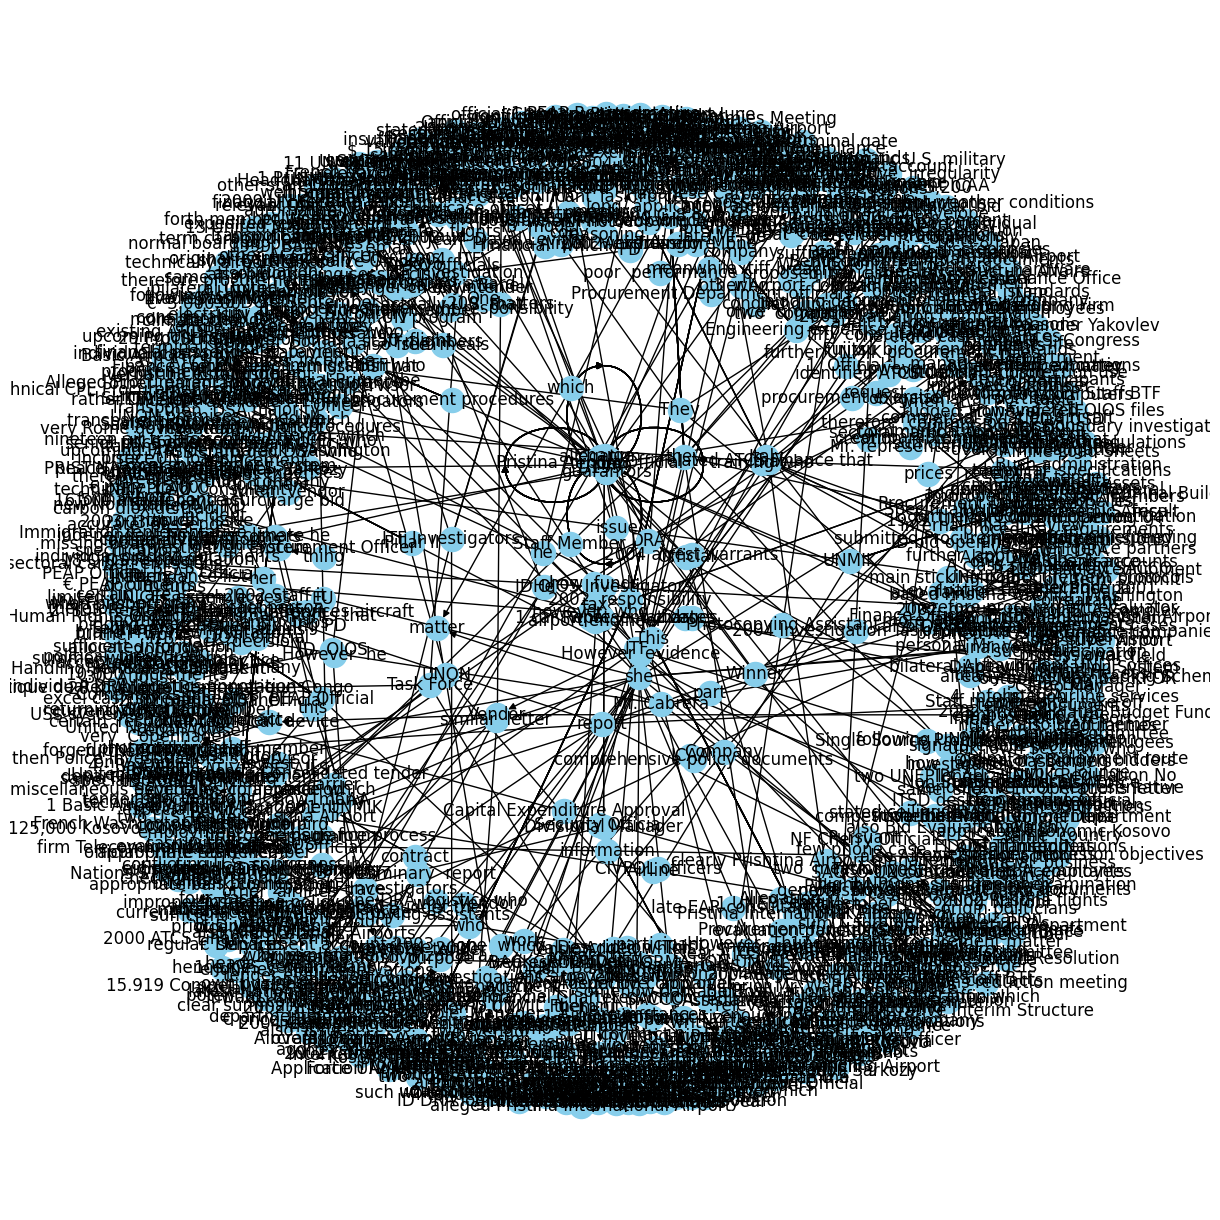

In [27]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()